In [127]:
import os
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pefile
import pickle
from pathlib import Path
from tqdm.notebook import tqdm
import hashlib
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('ggplot')
sns.set(font_scale=0.9)
plt.rcParams['figure.figsize'] = (12, 8)

In [128]:
MALWARE_DIR =  "data/malware" 
EXTRACTED_DIR = "data/extracted" 
PROCESSED_DIR = "data/processed"

### Unpacking/Deobfuscation

In [129]:
count = 0

def is_upx_packed(file_path):
    try:
        with open(file_path, 'rb') as f:
            content = f.read()
            return b'UPX!' in content
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return False
    
def unpack(file_path):
    try:
        # Will do it inplace.
        cmd = ["upx", "-d", str(file_path)]
        result = subprocess.run(cmd, capture_output=True, text=True)
        if result.returncode != 0:
            print(f"Error unpacking {file_path}: {result.stderr}")
            return None
        return file_path
    except Exception as e:
        print(f"Error unpacking {file_path}: {e}")
        return None
    

def deobfuscate(malware_dir): 
    for file_path in Path(malware_dir).glob('**/*'):
        if file_path.is_file() and is_upx_packed(file_path):
            unpacked_path = unpack(file_path)
            if (unpacked_path):
                global count
                count += 1

    
deobfuscate(MALWARE_DIR)
print(f"Unpacked {count} files.")

Unpacked 0 files.


##

In [130]:
def extract_file_metadata(file_path):
    file_bytes = file_path.read_bytes()
    return {
        'id': hashlib.md5(file_bytes).hexdigest(),
        'file_size': file_path.stat().st_size
    }

def extract_file_header(pe):
    return {
        'machine': pe.FILE_HEADER.Machine,
        'number_of_sections': pe.FILE_HEADER.NumberOfSections,
        'timestamp': pe.FILE_HEADER.TimeDateStamp,
        'characteristics': pe.FILE_HEADER.Characteristics
    }

def extract_optional_header(pe):
    if not hasattr(pe, 'OPTIONAL_HEADER'):
        return {}
    return {
        'subsystem': pe.OPTIONAL_HEADER.Subsystem,
        'dll_characteristics': pe.OPTIONAL_HEADER.DllCharacteristics,
        'size_of_code': pe.OPTIONAL_HEADER.SizeOfCode,
        'size_of_initialized_data': pe.OPTIONAL_HEADER.SizeOfInitializedData,
        'size_of_uninitialized_data': pe.OPTIONAL_HEADER.SizeOfUninitializedData,
        'entrypoint': pe.OPTIONAL_HEADER.AddressOfEntryPoint,
        'is_64bit': 1 if pe.OPTIONAL_HEADER.Magic == 0x20b else 0
    }

def extract_section_details(pe):
    section_names = []
    section_entropies = []
    section_sizes = []
    has_high_entropy_section = False

    for section in pe.sections:
        section_names.append(section.Name.decode('utf-8', 'ignore').strip('\x00'))
        section_sizes.append(section.SizeOfRawData)
        try:
            entropy = section.get_entropy()
            if entropy > 7.0:
                has_high_entropy_section = True
        except:
            entropy = 0
        section_entropies.append(entropy)

    return {
        'section_names': section_names,
        'section_entropies': section_entropies,
        'section_sizes': section_sizes,
        'has_high_entropy_section': has_high_entropy_section,
        'avg_section_entropy': np.mean(section_entropies) if section_entropies else 0
    }

def extract_imports(pe):
    imports = {}
    if not hasattr(pe, 'DIRECTORY_ENTRY_IMPORT'):
        return {'imports': imports, 'num_imported_dlls': 0, 'num_imported_functions': 0}

    for entry in pe.DIRECTORY_ENTRY_IMPORT:
        dll_name = entry.dll.decode('utf-8', 'ignore')
        imports[dll_name] = []
        try:
            for imp in entry.imports:
                if imp.name:
                    imports[dll_name].append(imp.name.decode('utf-8', 'ignore'))
                else:
                    imports[dll_name].append(f"ordinal_{imp.ordinal}")
        except:
            pass

    return {
        'imports': imports,
        'num_imported_dlls': len(imports),
        'num_imported_functions': sum(len(funcs) for funcs in imports.values())
    }

def extract_security_features(pe):
    return {
        'has_certificate': 1 if hasattr(pe, 'DIRECTORY_ENTRY_SECURITY') else 0,
        'has_debug': 1 if hasattr(pe, 'DIRECTORY_ENTRY_DEBUG') else 0,
        'has_tls': 1 if hasattr(pe, 'DIRECTORY_ENTRY_TLS') else 0,
        'has_load_config': 1 if hasattr(pe, 'DIRECTORY_ENTRY_LOAD_CONFIG') else 0
    }

def extract_features(malware_dir):
    all_features = []

    for file_path in Path(malware_dir).glob('**/*'):
        if not file_path.is_file():
            continue

        features = extract_file_metadata(file_path)

        try:
            pe = pefile.PE(file_path)
            features.update(extract_file_header(pe))
            features.update(extract_optional_header(pe))
            features.update(extract_section_details(pe))
            features.update(extract_imports(pe))
            features.update(extract_security_features(pe))
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue

        all_features.append(features)

    return pd.DataFrame(all_features).set_index('id')

data = extract_features(MALWARE_DIR)

Error processing data/malware/.DS_Store: 'DOS Header magic not found.'


In [131]:
data.head()

,file_size,machine,number_of_sections,timestamp,characteristics,subsystem,dll_characteristics,size_of_code,size_of_initialized_data,size_of_uninitialized_data,...,section_sizes,has_high_entropy_section,avg_section_entropy,imports,num_imported_dlls,num_imported_functions,has_certificate,has_debug,has_tls,has_load_config
id,,,,,,,,,,,,,,,,,,,,,
c16f2206815ed7a90cfccbe016de8862,8192,332,4,1242321160,271,2,0,4096,3072,0,...,"[4096, 2048, 512, 512]",False,3.130497,"{'KERNEL32.DLL': ['CloseHandle', 'WaitForSingl...",5,62,0,0,0,0
cefcce265f853877c15e98e9a562e4c4,8192,332,4,1242321160,271,2,0,4096,3072,0,...,"[4096, 2048, 512, 512]",False,3.132689,"{'KERNEL32.DLL': ['CloseHandle', 'WaitForSingl...",5,62,0,0,0,0
add869e77de67203223d83da817522b3,15360,332,3,1311923431,271,2,0,9728,4010496,0,...,"[9728, 3072, 1536]",False,4.836347,"{'KERNEL32.dll': ['CreateFileA', 'LocalAlloc',...",7,85,0,0,0,0
3096825c297f40c5a1efeb0afcb745b5,8192,332,4,1242321160,271,2,0,4096,3072,0,...,"[4096, 2048, 512, 512]",False,3.132658,"{'KERNEL32.DLL': ['CloseHandle', 'WaitForSingl...",5,62,0,0,0,0
59b8c35f30004beb1e59088993ef391f,8192,332,4,1242321160,271,2,0,4096,3072,0,...,"[4096, 2048, 512, 512]",False,3.124682,"{'KERNEL32.DLL': ['CloseHandle', 'WaitForSingl...",5,62,0,0,0,0


In [132]:
# Categorical features - these represent discrete categories or enumerations
categorical_features = {
    'machine': 'int32',           # CPU architecture type
    'characteristics': 'int32',   # PE file characteristics (bitmask)
    'subsystem': 'int32',         # Subsystem required to run the file
    'dll_characteristics': 'int32',  # DLL characteristics (bitmask)
}

# Complex features - these need special processing before clustering
complex_features = {
    'section_names': 'object',    # List of section names
    'imports': 'object',          # Dictionary of imported DLLs and functions
    'section_entropies': 'object',  # List of entropy values for each section
    'section_sizes': 'object',    # List of sizes for each section
}

# Numerical features - these are continuous or discrete numerical values
numerical_features = {
    'file_size': 'int64',         # Size of the file in bytes
    'number_of_sections': 'int32',  # Number of sections in the PE file
    'timestamp': 'int64',         # Compilation timestamp
    'size_of_code': 'int32',      # Size of code section
    'size_of_initialized_data': 'int32',  # Size of initialized data
    'size_of_uninitialized_data': 'int32',  # Size of uninitialized data
    'entrypoint': 'int32',        # Entry point address
    'avg_section_entropy': 'float32',  # Average entropy across all sections
    'num_imported_dlls': 'int32',  # Number of imported DLLs
    'num_imported_functions': 'int32',  # Total number of imported functions
}

# Boolean features - these are binary indicators (0/1)
boolean_features = {
    'is_64bit': 'int8',           # Whether the file is 64-bit (1) or 32-bit (0)
    'has_high_entropy_section': 'int8',  # Whether any section has entropy > 7.0
    'has_certificate': 'int8',    # Whether the file has a certificate
    'has_debug': 'int8',          # Whether the file has debug information
    'has_tls': 'int8',            # Whether the file has TLS callbacks
    'has_load_config': 'int8'     # Whether the file has load configuration
}

# Cast all columns to their appropriate types
def cast_columns(data, feature_types):
    for col, dtype in feature_types.items():
        if col in data.columns:
            data[col] = data[col].astype(dtype)
    return data

# Combine all feature types and cast columns
all_features = {**categorical_features, **complex_features, **numerical_features, **boolean_features}
data = cast_columns(data, all_features)

### Exploration

Dataset shape: (40, 24)
Number of samples: 40
Number of features: 24

Missing values per column:
file_size                     0
machine                       0
number_of_sections            0
timestamp                     0
characteristics               0
subsystem                     0
dll_characteristics           0
size_of_code                  0
size_of_initialized_data      0
size_of_uninitialized_data    0
entrypoint                    0
is_64bit                      0
section_names                 0
section_entropies             0
section_sizes                 0
has_high_entropy_section      0
avg_section_entropy           0
imports                       0
num_imported_dlls             0
num_imported_functions        0
has_certificate               0
has_debug                     0
has_tls                       0
has_load_config               0
dtype: int64

Feature categories:
Categorical features: ['machine', 'characteristics', 'subsystem', 'dll_characteristics']
Numerical fe

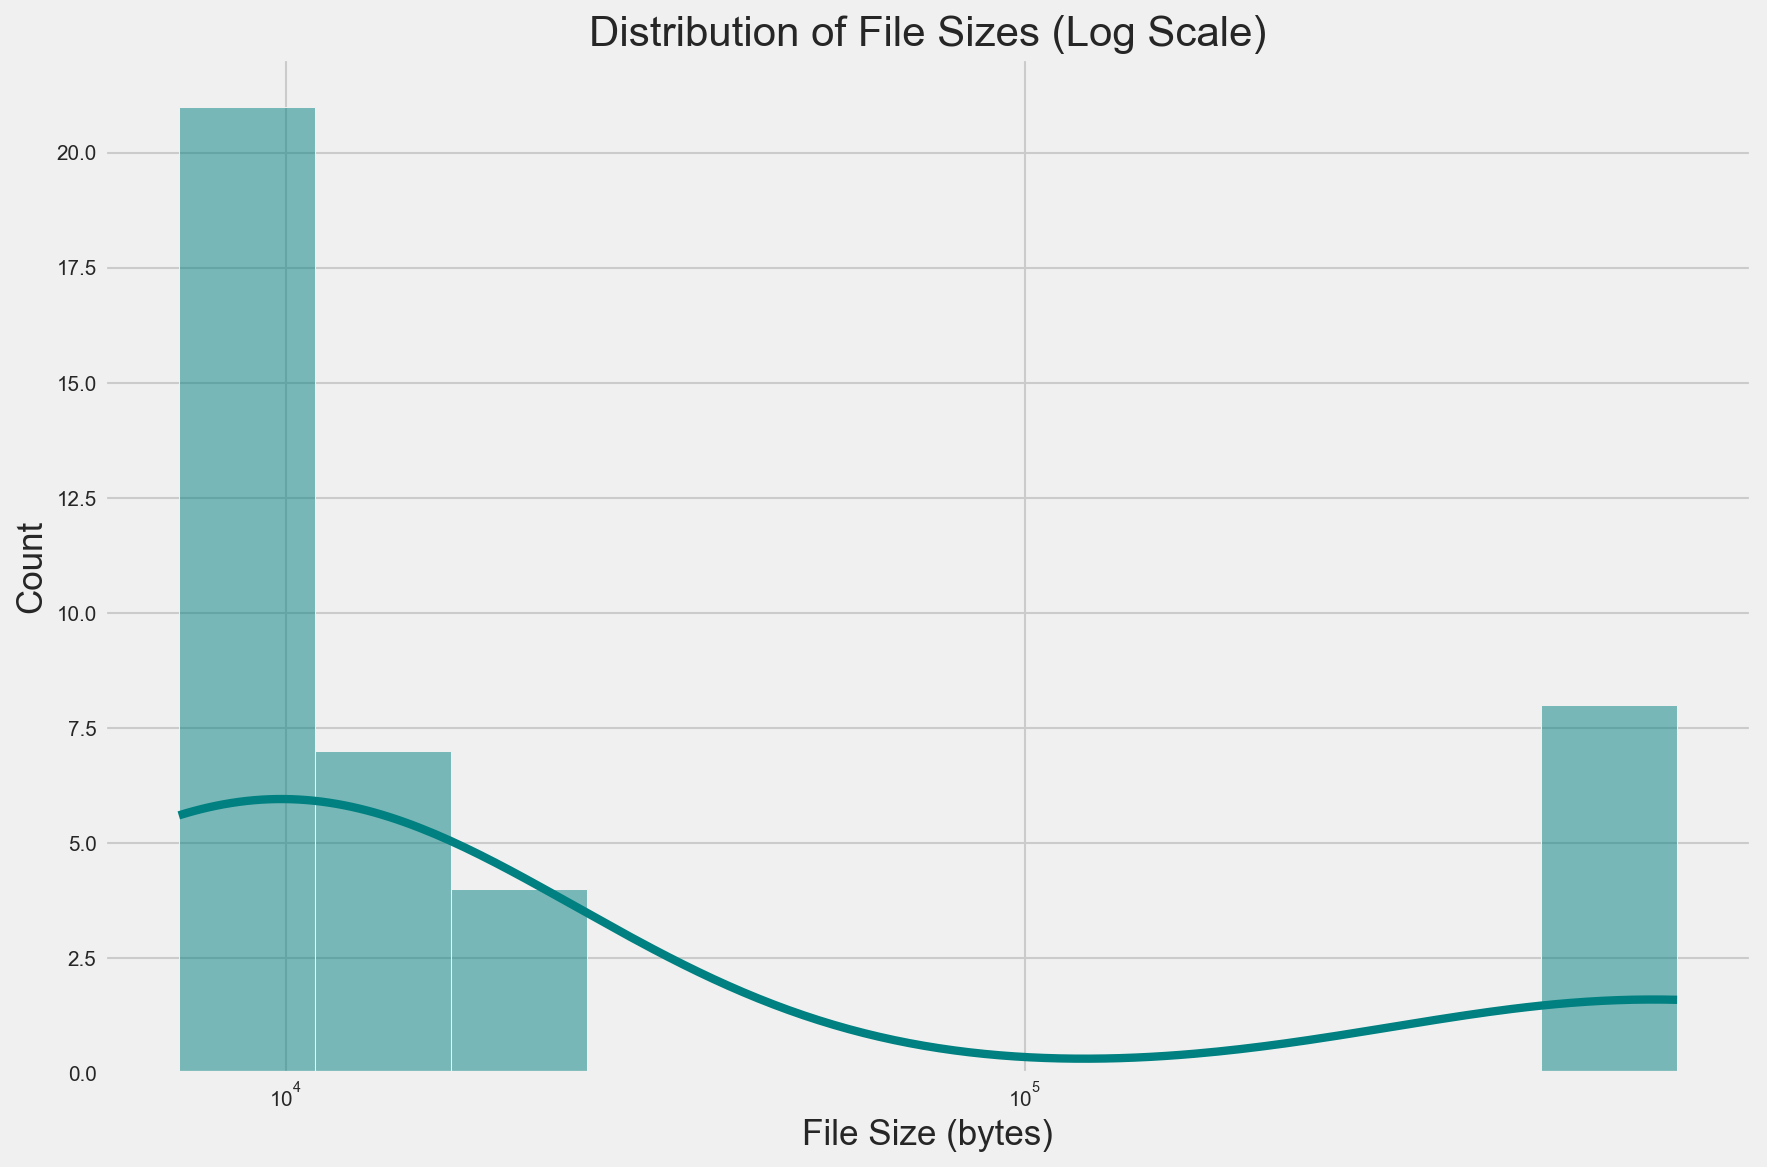

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


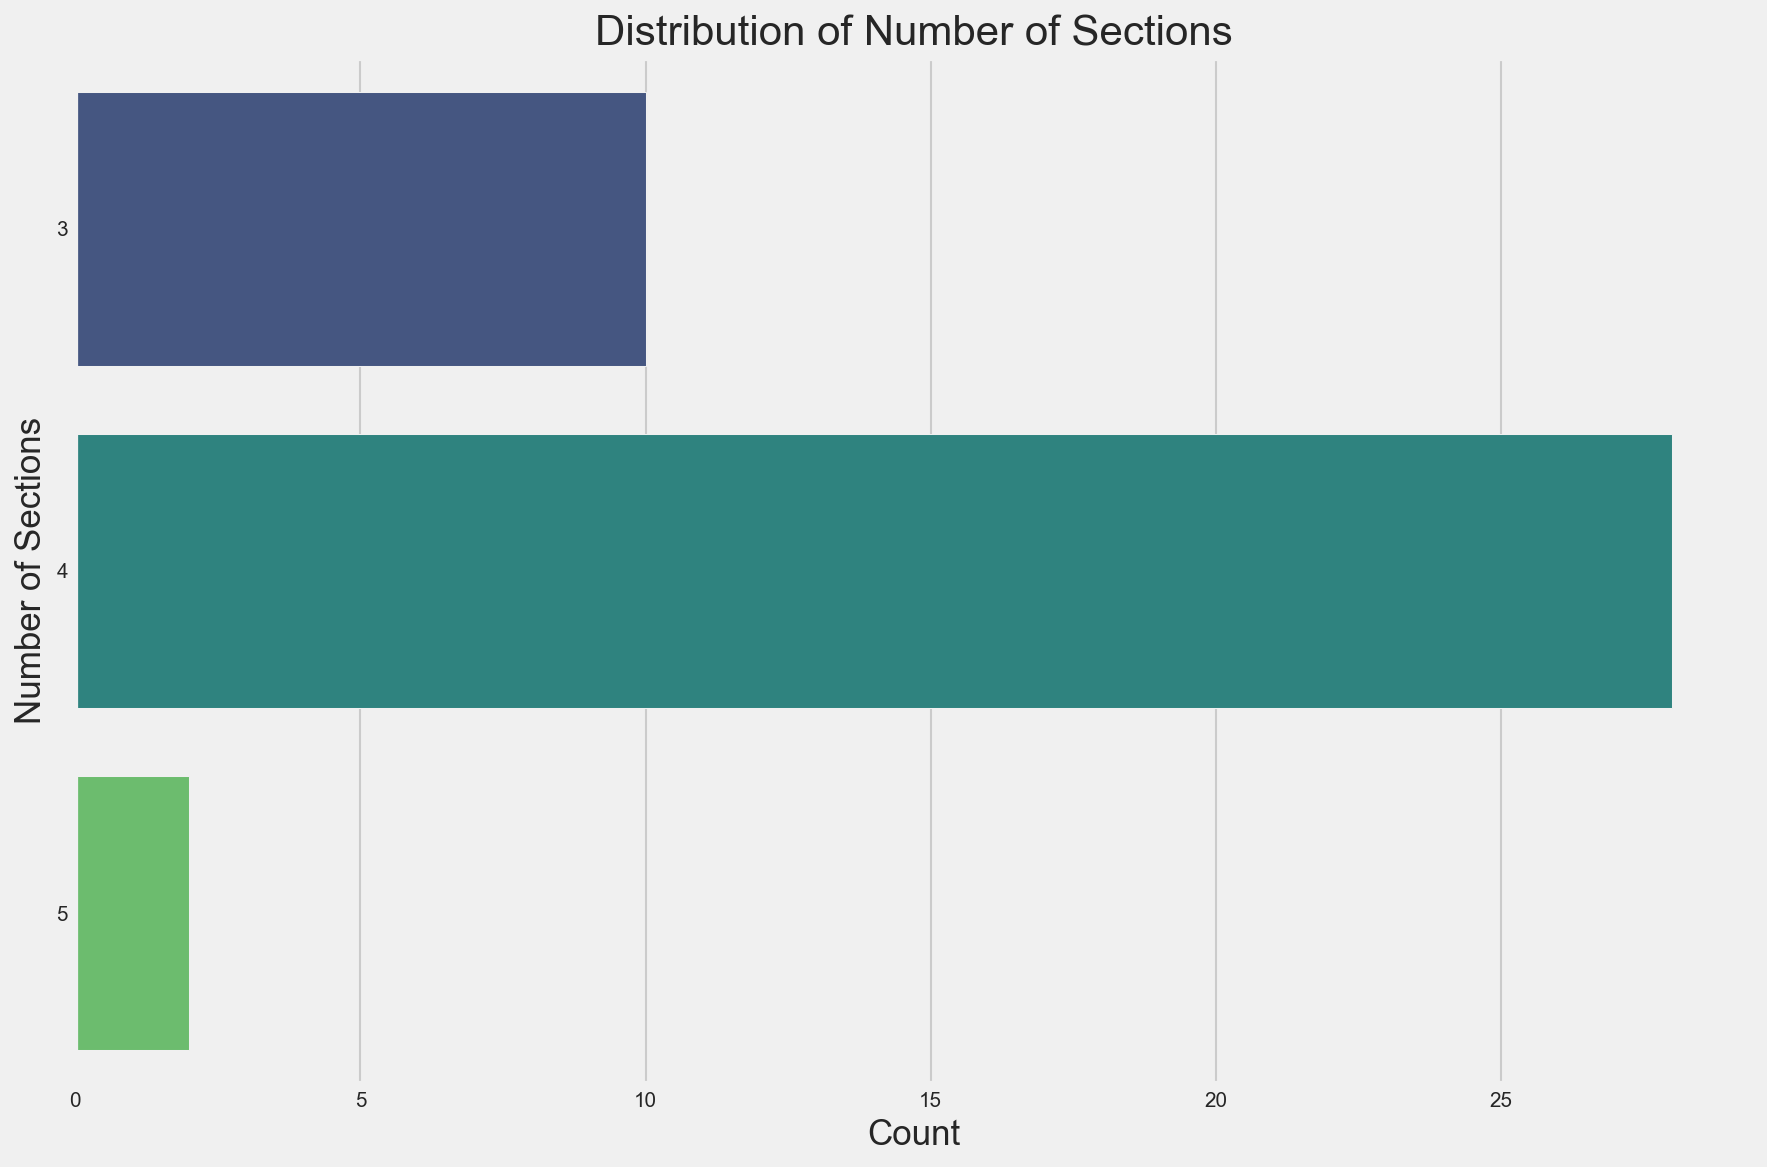

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


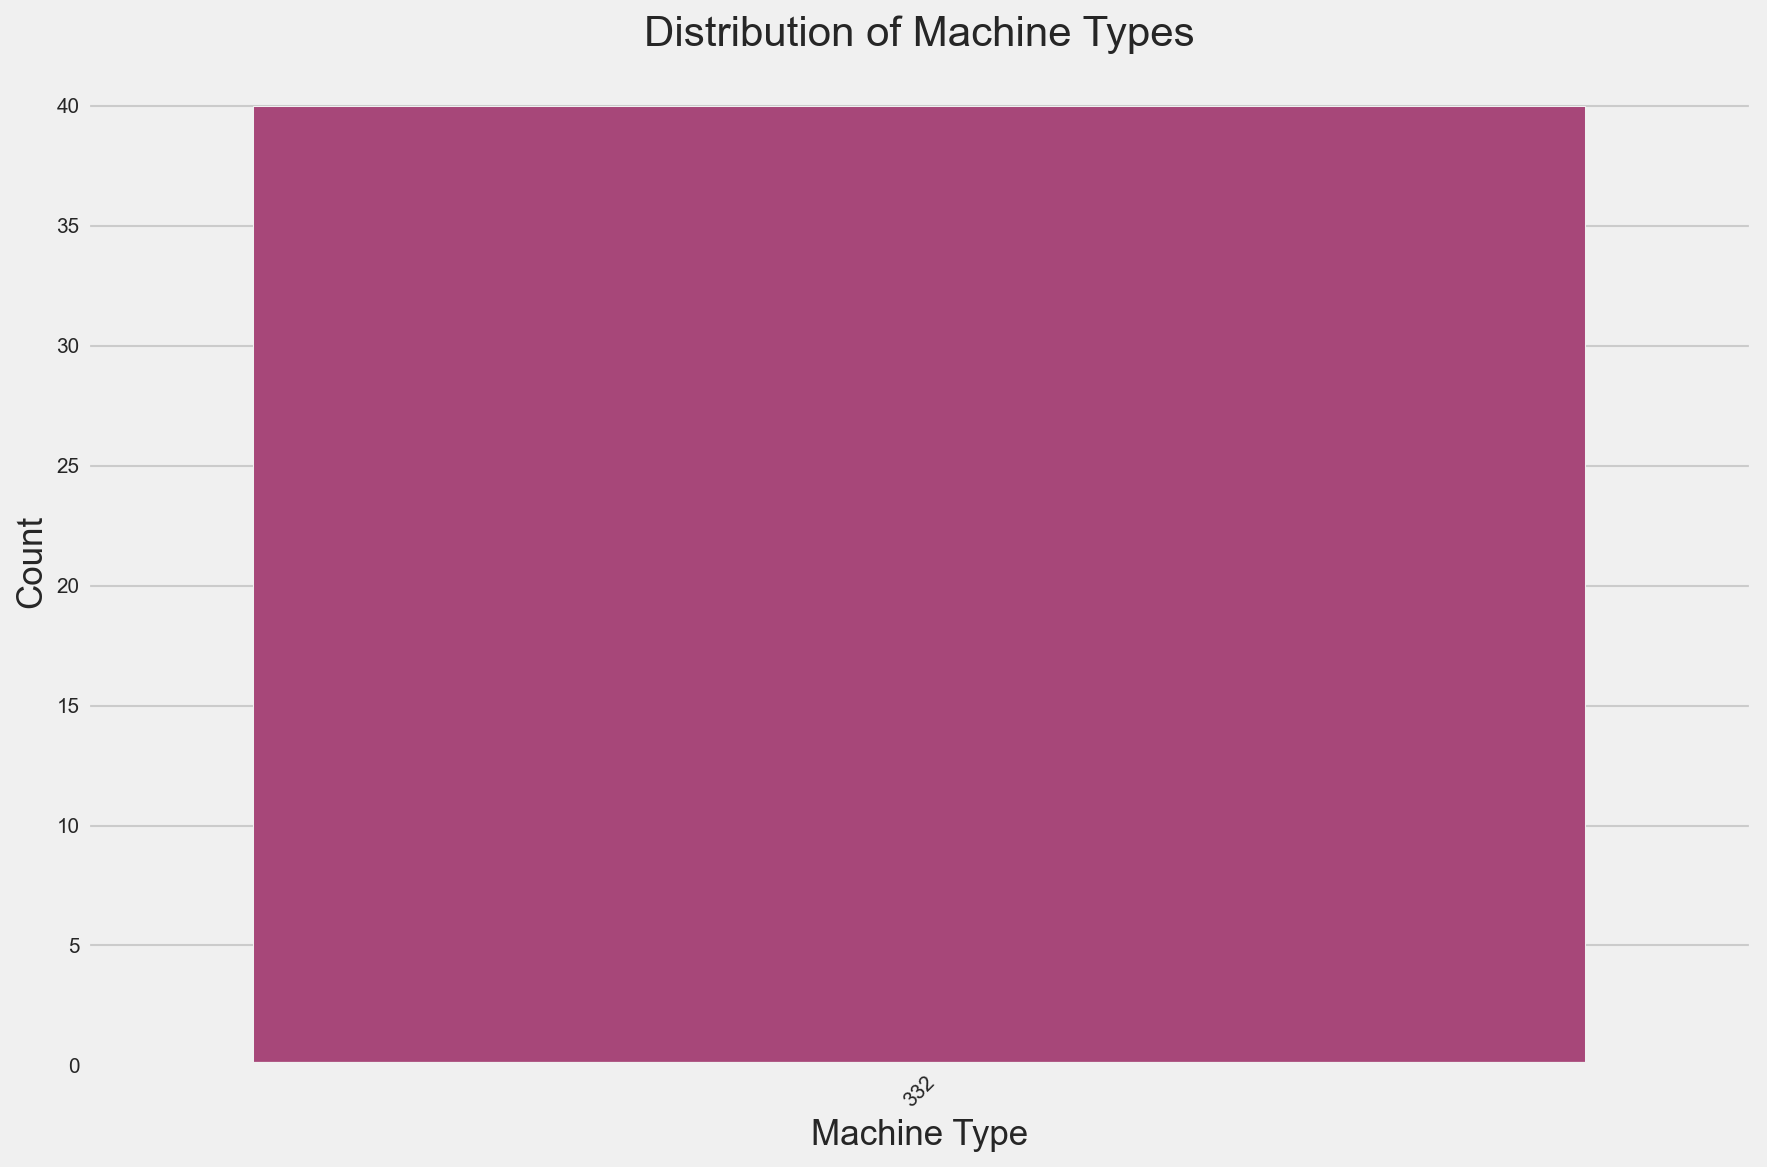

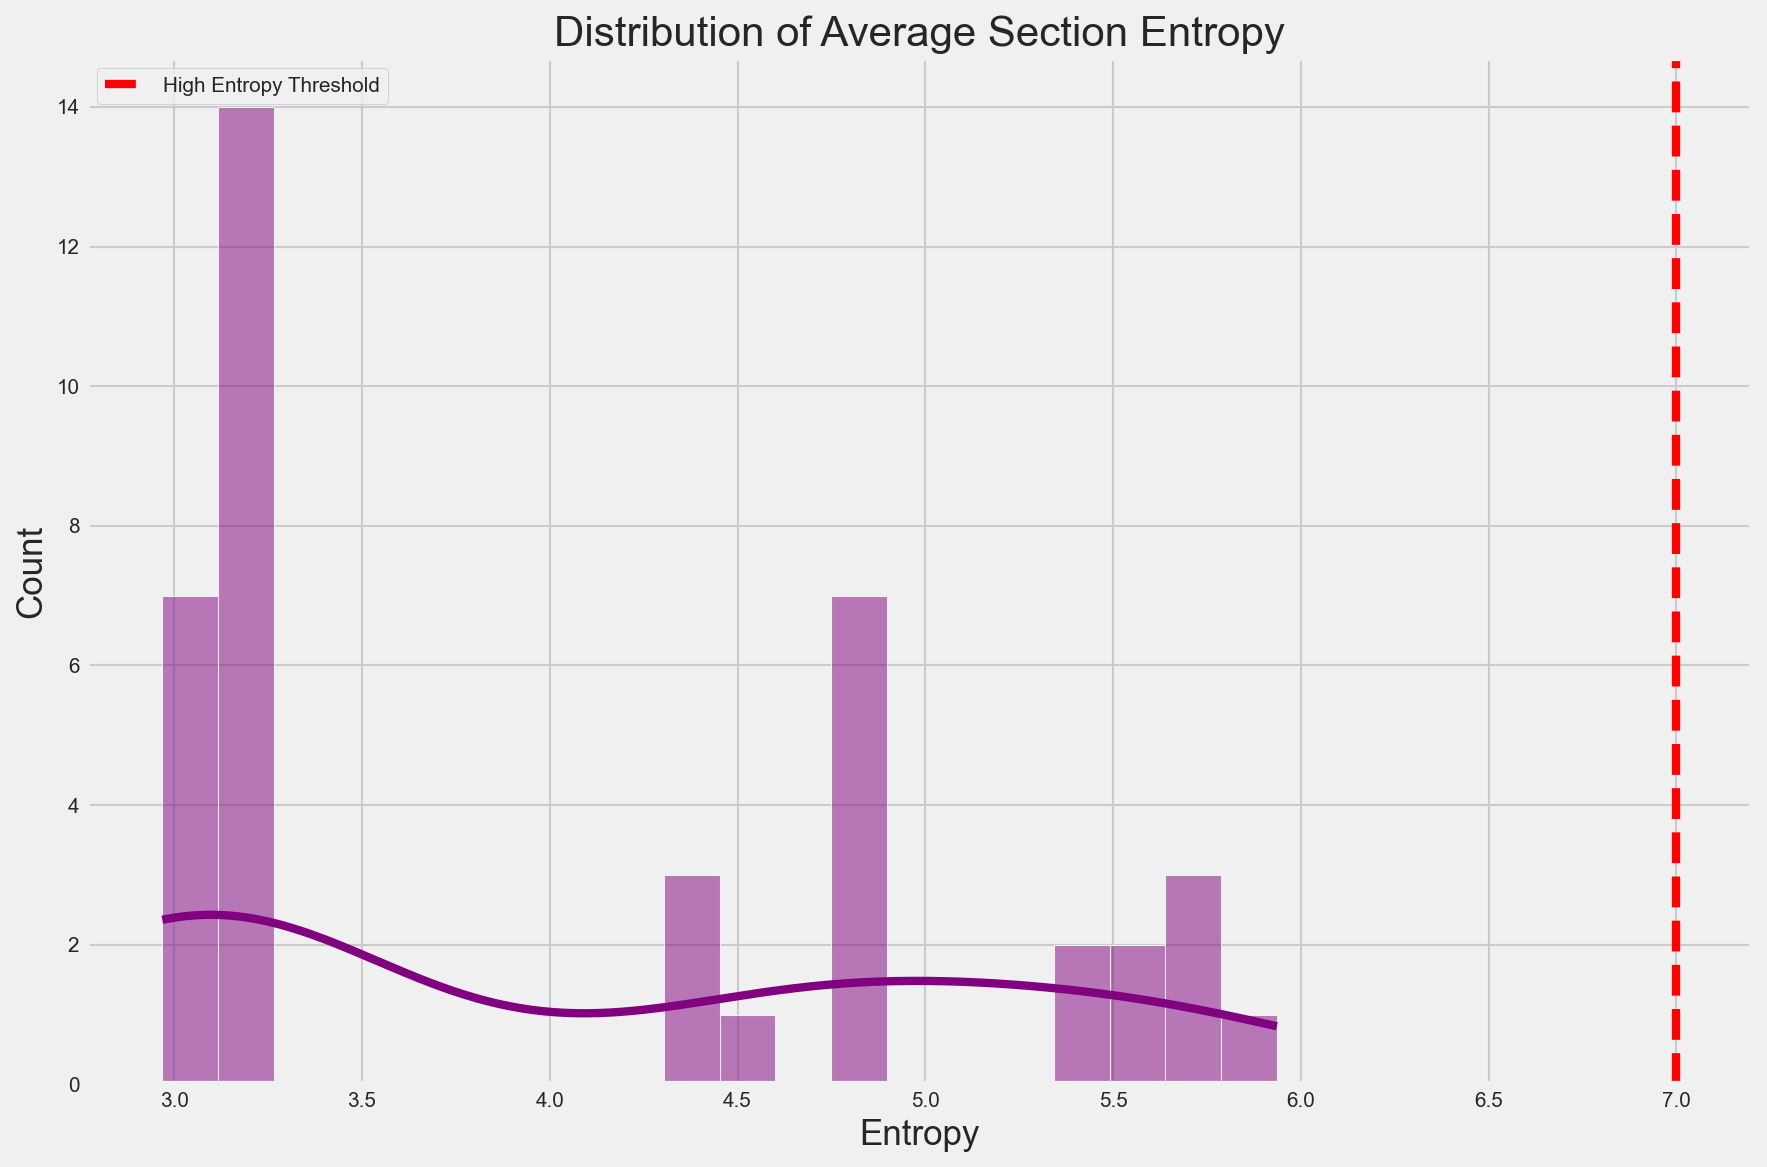

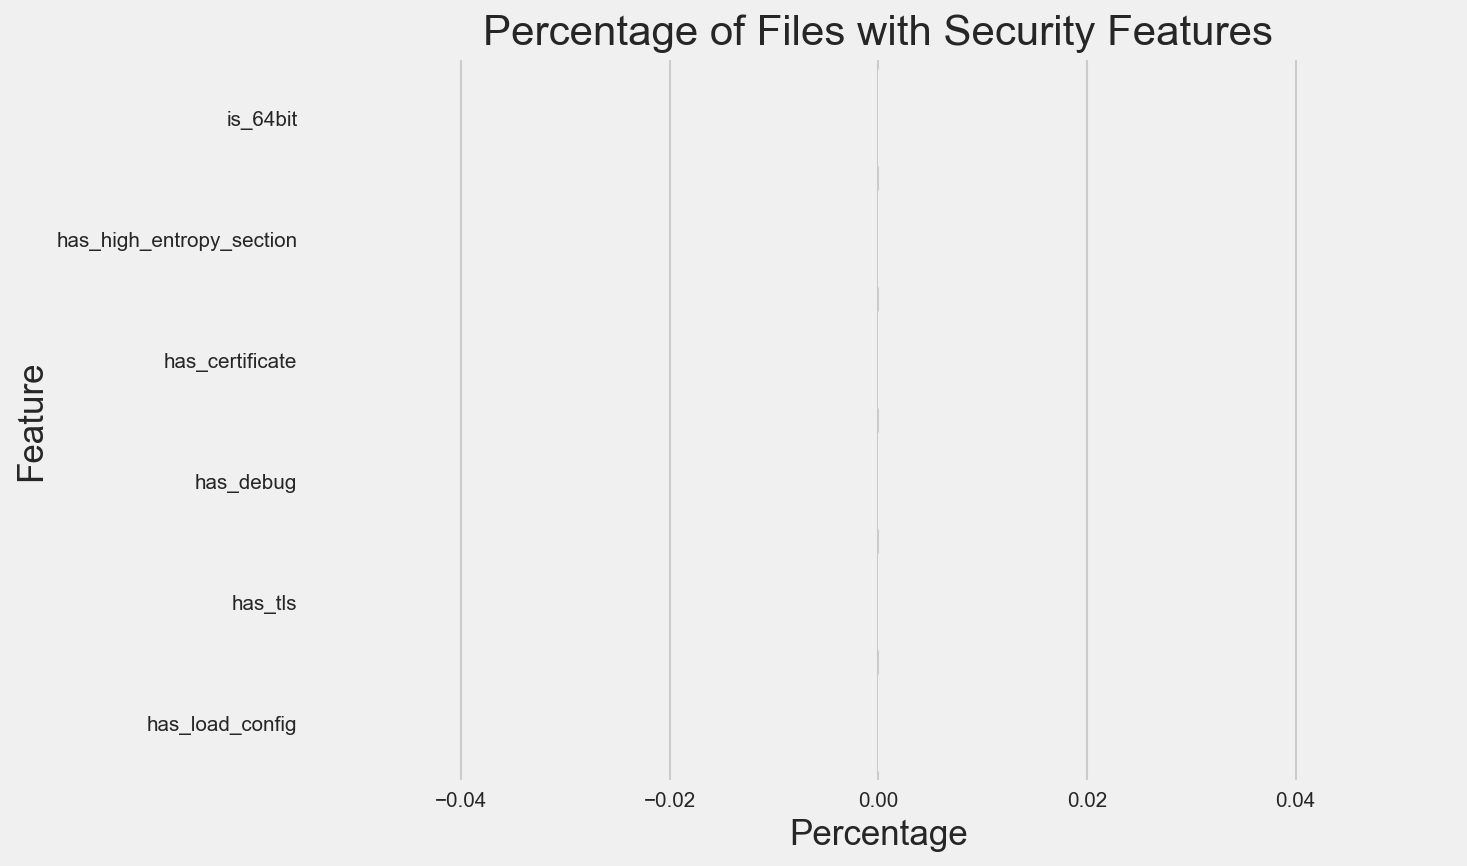

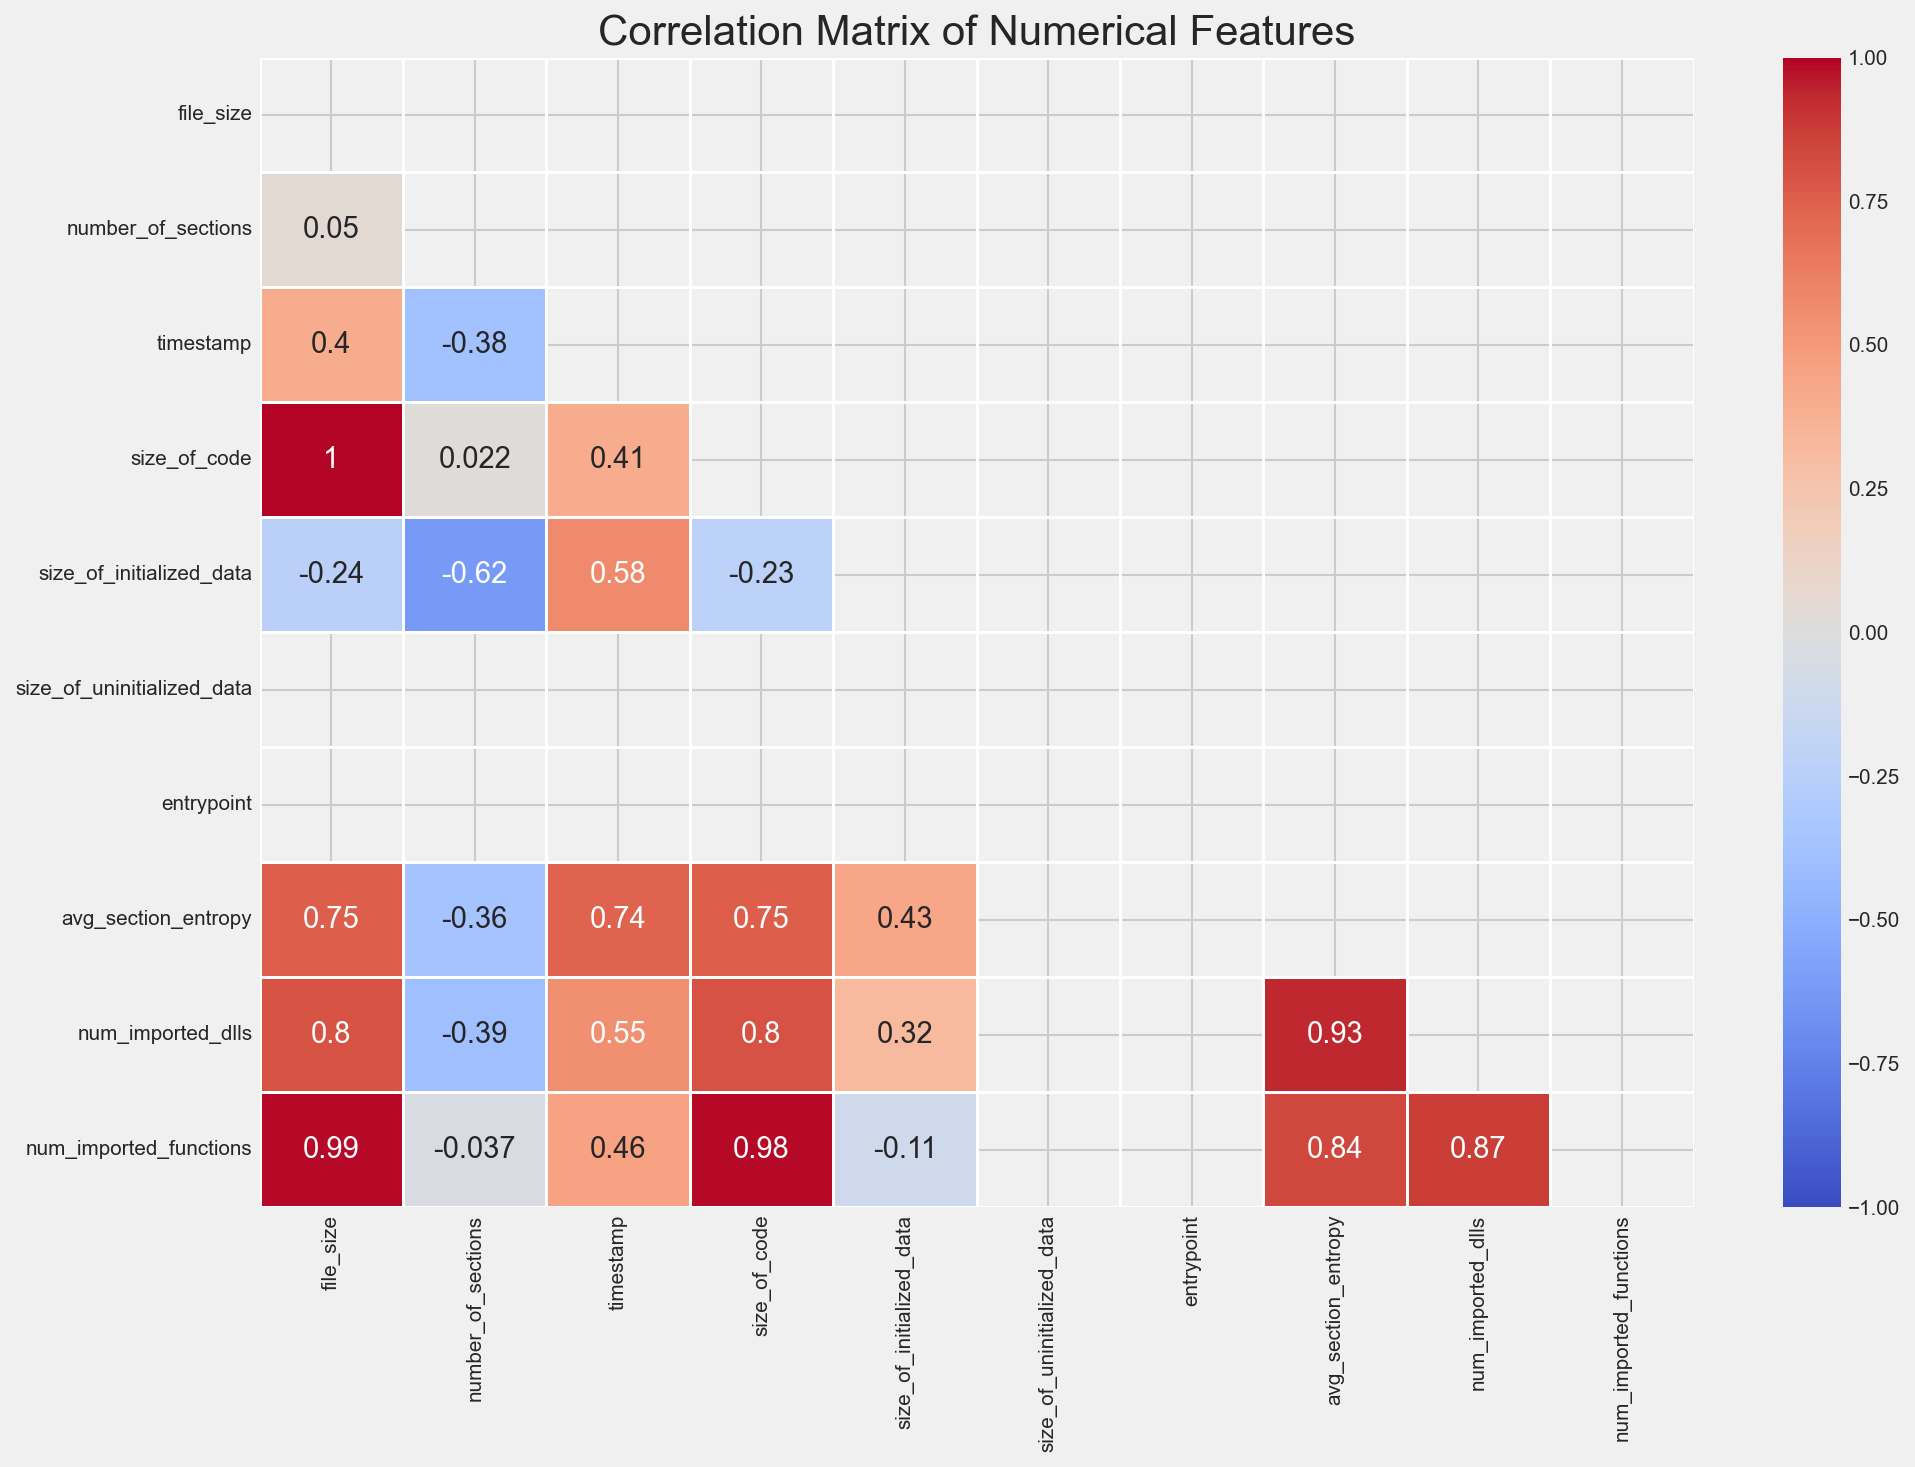

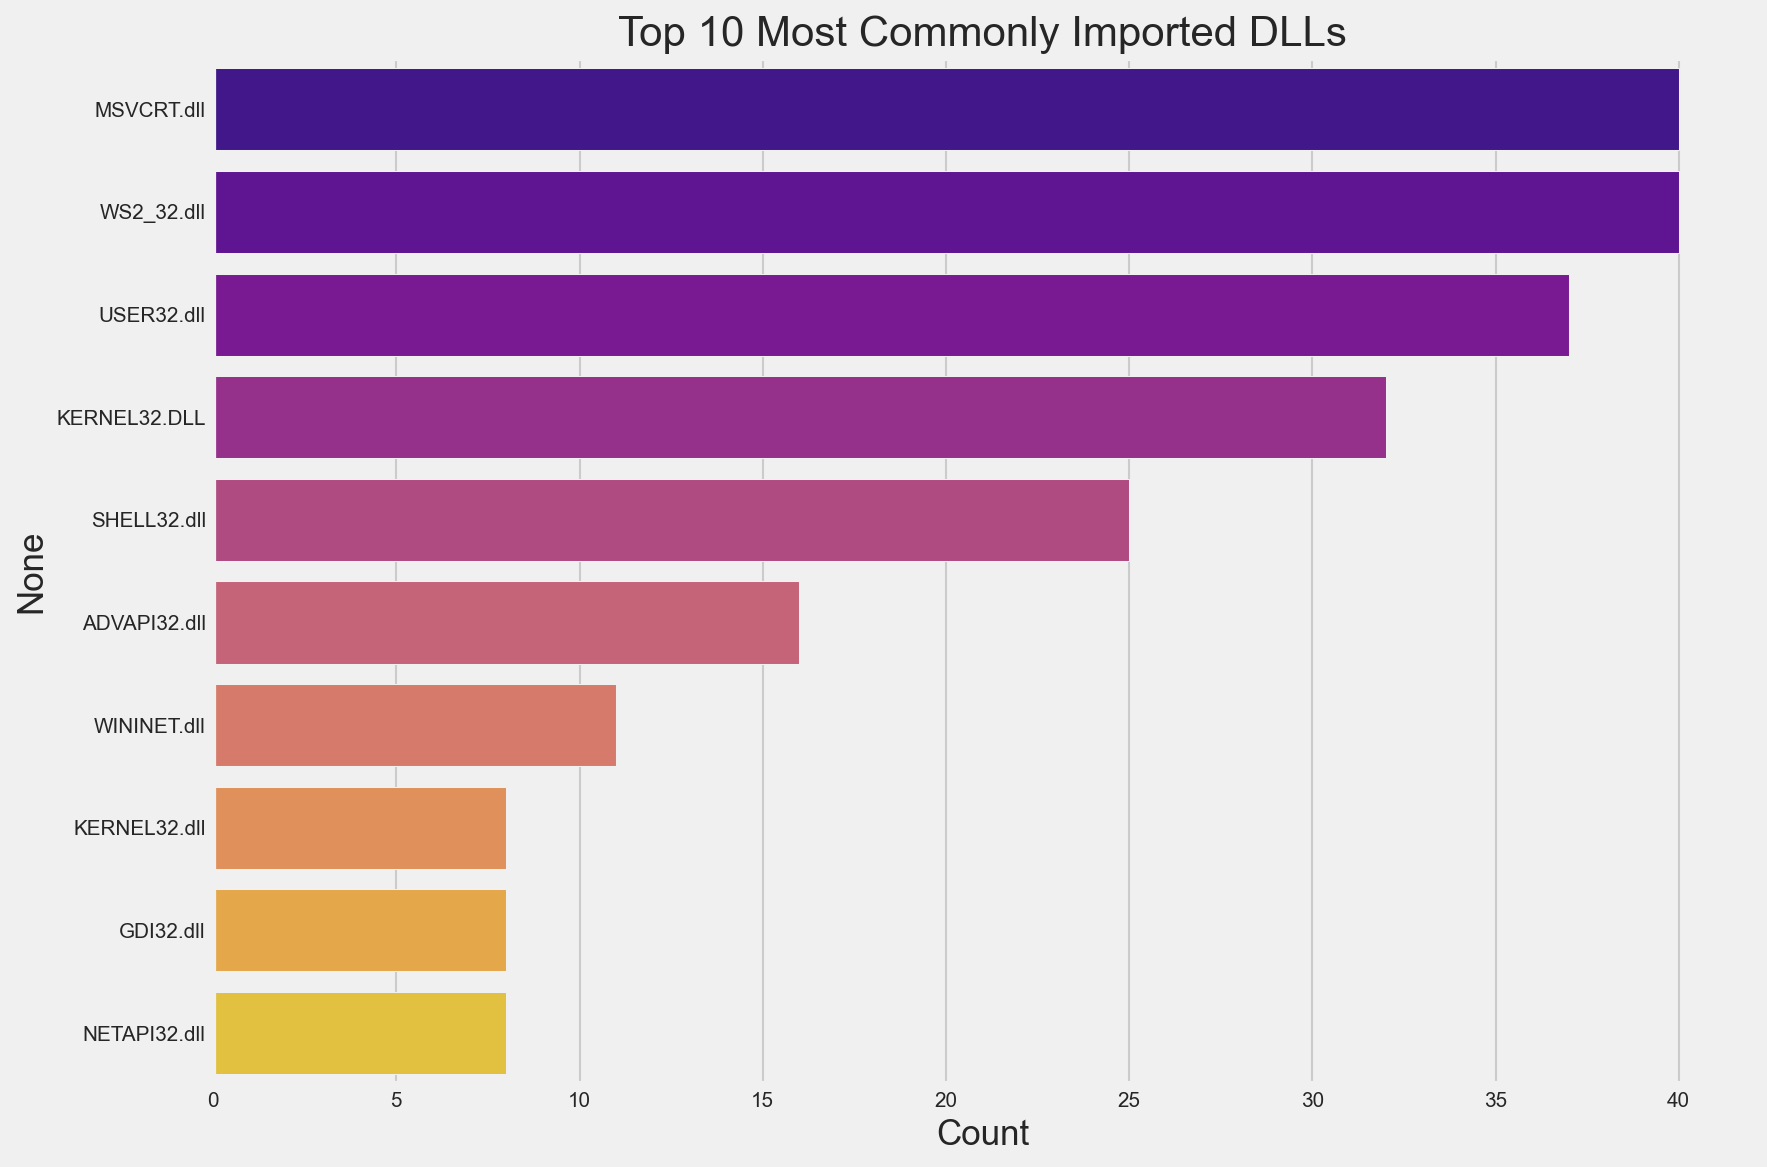

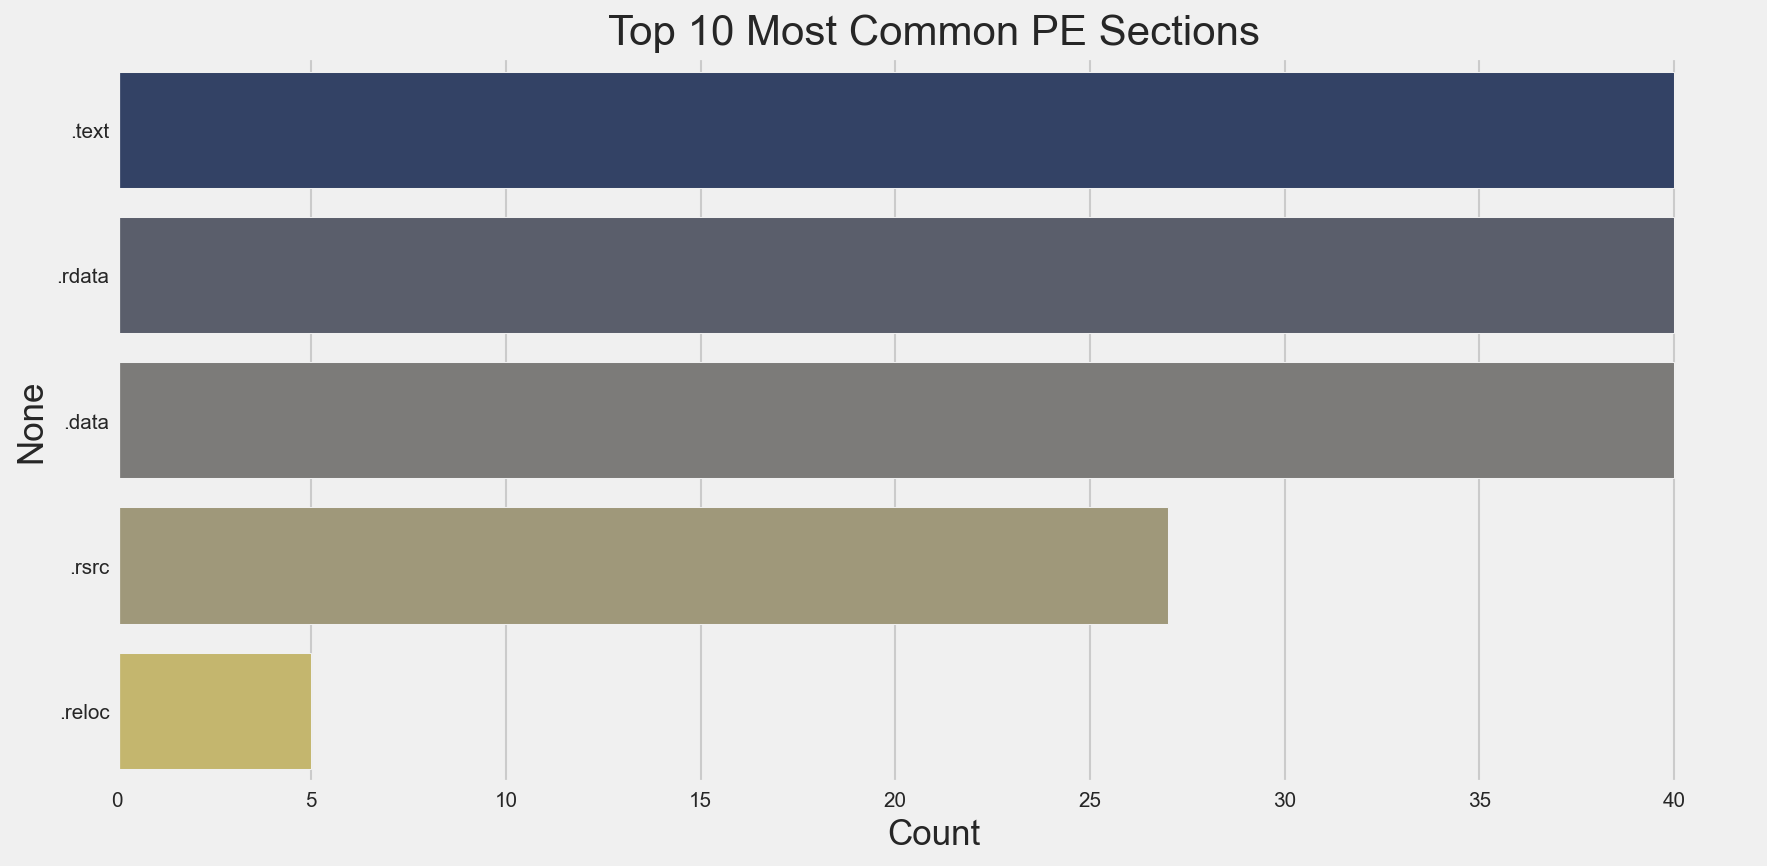

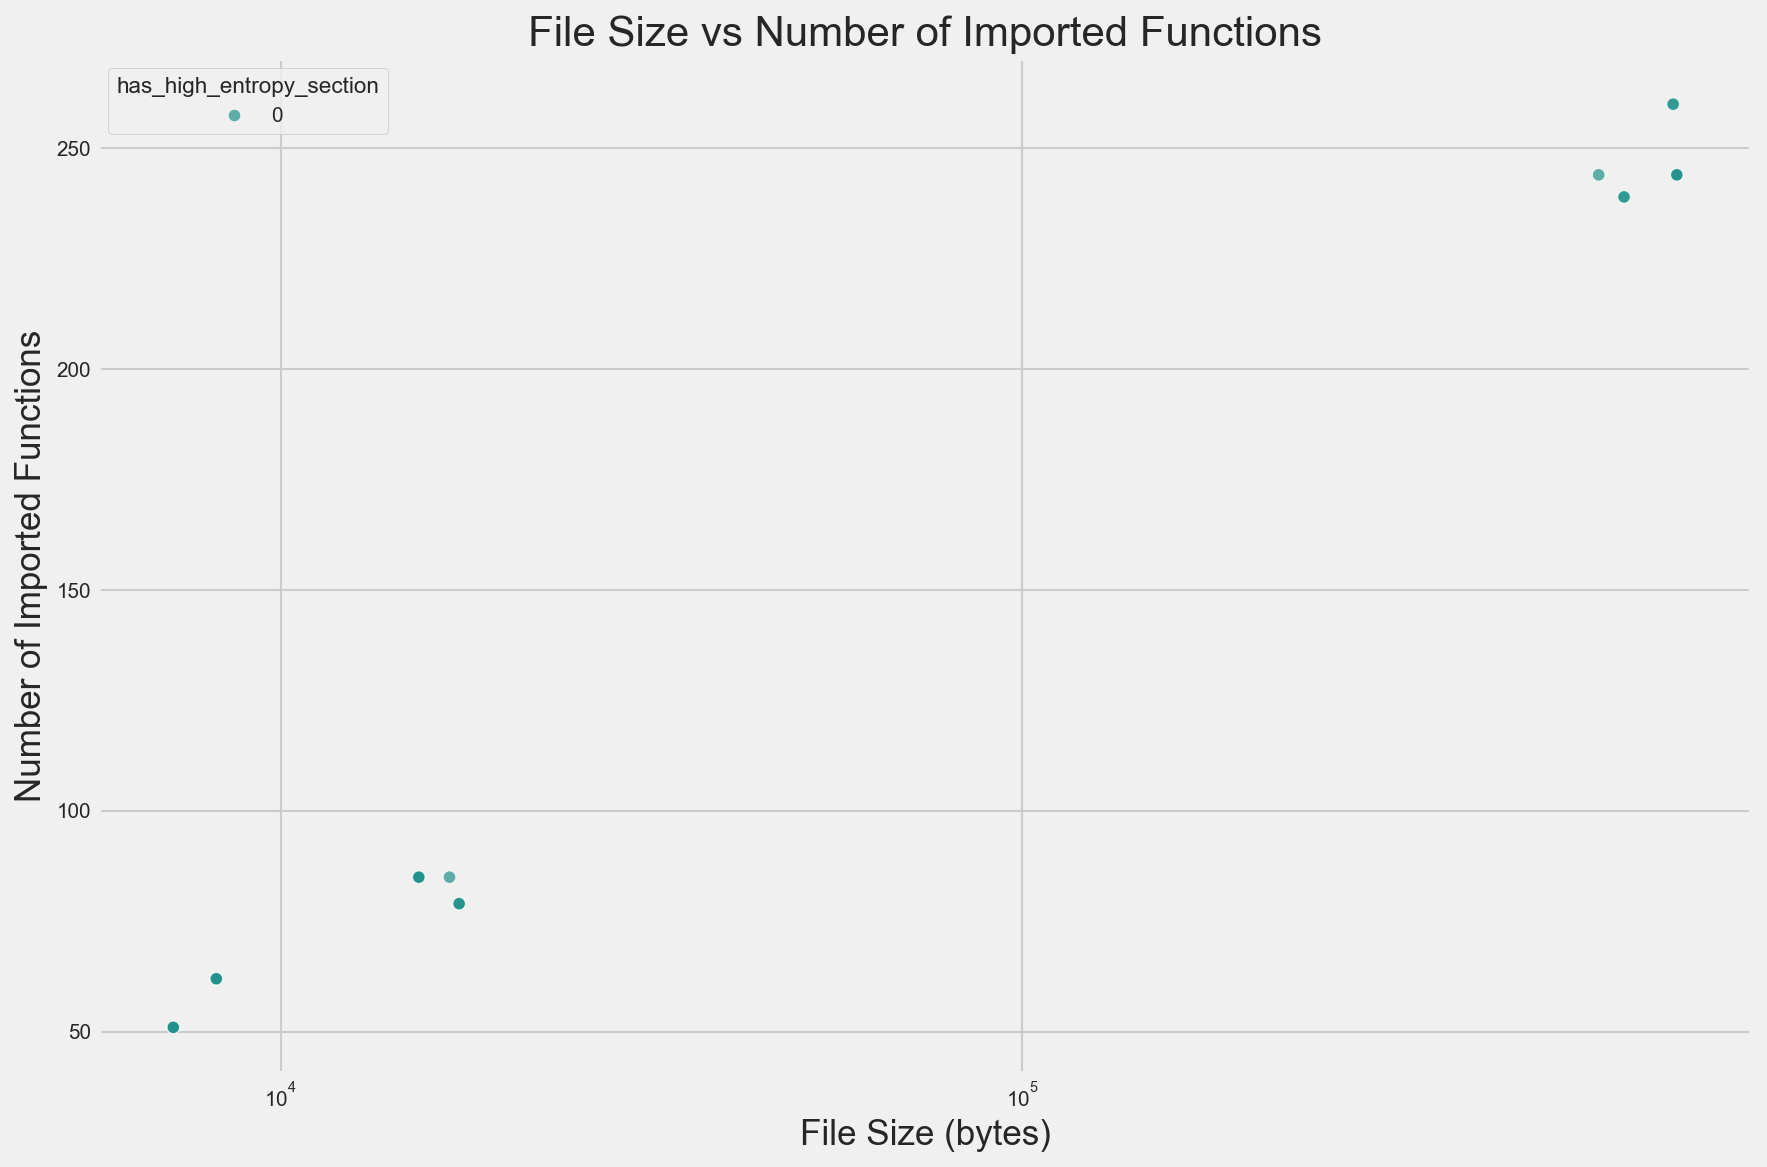

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set style and color palette
plt.style.use('fivethirtyeight')
sns.set_palette('viridis')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (12, 8)

# 1. Dataset Overview
print(f"Dataset shape: {data.shape}")
print(f"Number of samples: {data.shape[0]}")
print(f"Number of features: {data.shape[1]}")
print("\nMissing values per column:")
print(data.isnull().sum())

# Display feature categories
print("\nFeature categories:")
print(f"Categorical features: {list(categorical_features.keys())}")
print(f"Numerical features: {list(numerical_features.keys())}")
print(f"Boolean features: {list(boolean_features.keys())}")
print(f"Complex features: {list(complex_features.keys())}")

# 2. Basic statistics for numerical features
numerical_stats = data[list(numerical_features.keys())].describe()
print("\nNumerical Features Statistics:")
print(numerical_stats)

# 3. Visualizations

# File size distribution (log scale)
plt.figure()
sns.histplot(data['file_size'], log_scale=(True, False), kde=True, color='teal')
plt.title('Distribution of File Sizes (Log Scale)')
plt.xlabel('File Size (bytes)')
plt.tight_layout()
plt.show()

# Number of sections distribution
plt.figure()
sns.countplot(y=data['number_of_sections'], palette='viridis')
plt.title('Distribution of Number of Sections')
plt.xlabel('Count')
plt.ylabel('Number of Sections')
plt.tight_layout()
plt.show()

# Architecture types
plt.figure()
machine_counts = data['machine'].value_counts()
sns.barplot(x=machine_counts.index, y=machine_counts.values, palette='magma')
plt.title('Distribution of Machine Types')
plt.xlabel('Machine Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Average section entropy
plt.figure()
sns.histplot(data['avg_section_entropy'], bins=20, kde=True, color='purple')
plt.title('Distribution of Average Section Entropy')
plt.xlabel('Entropy')
plt.axvline(7.0, color='red', linestyle='--', label='High Entropy Threshold')
plt.legend()
plt.tight_layout()
plt.show()

# Boolean features heatmap
plt.figure(figsize=(10, 6))
boolean_data = data[list(boolean_features.keys())].mean().reset_index()
boolean_data.columns = ['Feature', 'Percentage']
boolean_data = boolean_data.sort_values('Percentage', ascending=False)

sns.barplot(x='Percentage', y='Feature', data=boolean_data, palette='YlOrRd')
plt.title('Percentage of Files with Security Features')
plt.xlabel('Percentage')
plt.tight_layout()
plt.show()

# Correlation heatmap of numerical features
plt.figure(figsize=(14, 10))
corr_matrix = data[list(numerical_features.keys())].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', 
            linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

# Imports analysis - Top 10 most common DLLs
plt.figure(figsize=(12, 8))
# Extract all DLL names from the imports dictionary
all_dlls = []
for imp_dict in data['imports'].dropna():
    all_dlls.extend(list(imp_dict.keys()))
    
dll_counts = pd.Series(all_dlls).value_counts().head(10)
sns.barplot(x=dll_counts.values, y=dll_counts.index, palette='plasma')
plt.title('Top 10 Most Commonly Imported DLLs')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

# Section names analysis - Top 10 most common sections
plt.figure(figsize=(12, 6))
all_sections = []
for sections in data['section_names'].dropna():
    all_sections.extend(sections)
    
section_counts = pd.Series(all_sections).value_counts().head(10)
sns.barplot(x=section_counts.values, y=section_counts.index, palette='cividis')
plt.title('Top 10 Most Common PE Sections')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

# File size vs number of imported functions scatter plot
plt.figure()
sns.scatterplot(x='file_size', y='num_imported_functions', 
                hue='has_high_entropy_section', data=data, palette='viridis', alpha=0.7)
plt.title('File Size vs Number of Imported Functions')
plt.xlabel('File Size (bytes)')
plt.ylabel('Number of Imported Functions')
plt.xscale('log')
plt.tight_layout()
plt.show()

### Preprocessing

In [137]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold


def extract_section_features(df, top_n_sections=10):
    all_sections = []
    for sections in df["section_names"].dropna():
        all_sections.extend(sections)

    top_sections = (
        pd.Series(all_sections).value_counts().head(top_n_sections).index.tolist()
    )

    for section in top_sections:
        df[f"has_section_{section}"] = df["section_names"].apply(
            lambda x: 1 if isinstance(x, list) and section in x else 0
        )

    return df, [f"has_section_{section}" for section in top_sections]


def extract_dll_features(df, top_n_dlls=20):
    all_dlls = []
    for imp_dict in df["imports"].dropna():
        if isinstance(imp_dict, dict):
            all_dlls.extend(list(imp_dict.keys()))

    top_dlls = pd.Series(all_dlls).value_counts().head(top_n_dlls).index.tolist()

    for dll in top_dlls:
        df[f"has_dll_{dll}"] = df["imports"].apply(
            lambda x: 1 if isinstance(x, dict) and dll in x else 0
        )

    return df, [f"has_dll_{dll}" for dll in top_dlls]

def extract_entropy_features(df):
    df["min_entropy"] = df["section_entropies"].apply(
        lambda x: min(x) if isinstance(x, list) and len(x) > 0 else 0
    )
    df["max_entropy"] = df["section_entropies"].apply(
        lambda x: max(x) if isinstance(x, list) and len(x) > 0 else 0
    )
    df["std_entropy"] = df["section_entropies"].apply(
        lambda x: np.std(x) if isinstance(x, list) and len(x) > 0 else 0
    )

    return df, ["min_entropy", "max_entropy", "std_entropy"]


def extract_size_features(df):
    df["min_section_size"] = df["section_sizes"].apply(
        lambda x: min(x) if isinstance(x, list) and len(x) > 0 else 0
    )
    df["max_section_size"] = df["section_sizes"].apply(
        lambda x: max(x) if isinstance(x, list) and len(x) > 0 else 0
    )
    df["std_section_size"] = df["section_sizes"].apply(
        lambda x: np.std(x) if isinstance(x, list) and len(x) > 0 else 0
    )

    return df, ["min_section_size", "max_section_size", "std_section_size"]


def encode_categorical_features(df, categorical_features):
    encoded_feature_names = []

    for col, dtype in categorical_features.items():
        if col in df.columns:
            df[col] = df[col].astype(str)
            dummies = pd.get_dummies(df[col], prefix=col)

            for dummy_col in dummies.columns:
                dummies[dummy_col] = dummies[dummy_col].astype(int)
            df = pd.concat([df, dummies], axis=1)
            encoded_feature_names.extend(dummies.columns.tolist())

    return df, encoded_feature_names


def handle_missing_values(df):

    for col in df.columns:
        if hasattr(df[col], "cat") and isinstance(df[col].dtype, pd.CategoricalDtype):
            df[col] = df[col].astype(str)

    for col in df.columns:
        if df[col].dtype == "object":
            try:
                df[col] = pd.to_numeric(df[col], errors="raise")
            except (ValueError, TypeError):
                pass

    return df.fillna(0)


def scale_numerical_features(df, numerical_cols, binary_cols):
    """
    Scale only numerical features, preserving binary features as 0/1
    """
    print(binary_cols)

    for col in binary_cols:
        if col in df.columns:
            df[col] = df[col].astype(int)

    cols_to_scale = [
        col
        for col in df.columns
        if col in numerical_cols
        and col not in binary_cols
        and df[col].dtype in ["int64", "float64", "int32", "float32"]
    ]

    if cols_to_scale:
        scaler = StandardScaler()
        df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

    return df


def select_features(df, min_variance=0.01):
    selector = VarianceThreshold(threshold=min_variance)

    feature_names = df.columns.tolist()

    selected_features = selector.fit_transform(df)

    selected_features_mask = selector.get_support()

    selected_feature_names = [
        feature_names[i] for i in range(len(feature_names)) if selected_features_mask[i]
    ]

    return df[selected_feature_names]


def preprocess_malware_data(
    data,
    categorical_features,
    complex_features,
    numerical_features,
    boolean_features,
    top_n_dlls=20,
    top_n_sections=10,
):
    df = data.copy()

    df.drop(columns=['timestamp'], inplace=True)

    for col in df.select_dtypes(include=["category"]).columns:
        df[col] = df[col].astype(str)

    df, section_features = extract_section_features(df, top_n_sections)
    df, dll_features = extract_dll_features(df, top_n_dlls)
    df, entropy_features = extract_entropy_features(df)
    df, size_features = extract_size_features(df)

    df, categorical_encoded_features = encode_categorical_features(
        df, categorical_features
    )

    df = handle_missing_values(df)

    features_to_keep = (
        list(numerical_features.keys())
        + list(boolean_features.keys())
        + section_features
        + dll_features
        + entropy_features
        + size_features
        + categorical_encoded_features
    )

    columns_to_drop = list(complex_features.keys()) + list(categorical_features.keys())
    df_processed = df.drop(
        columns=[col for col in columns_to_drop if col in df.columns]
    )

    df_processed = df_processed[
        [col for col in features_to_keep if col in df_processed.columns]
    ]

    all_binary_features = (
        list(boolean_features.keys()) + section_features + categorical_encoded_features
    )

    all_numerical_features = (
        list(numerical_features.keys())
        + entropy_features
        + size_features
    )

    df_processed = scale_numerical_features(
        df_processed, all_numerical_features, all_binary_features
    )

    df_processed = select_features(df_processed)

    print(f"Final dataset shape: {df_processed.shape}")
    return df_processed


final_data = preprocess_malware_data(
    data,
    categorical_features=categorical_features,
    complex_features=complex_features,
    numerical_features=numerical_features,
    boolean_features=boolean_features,
    top_n_dlls=15,
    top_n_sections=10,
)
final_data.to_csv("data/processed_data.csv")

['is_64bit', 'has_high_entropy_section', 'has_certificate', 'has_debug', 'has_tls', 'has_load_config', 'has_section_.text', 'has_section_.rdata', 'has_section_.data', 'has_section_.rsrc', 'has_section_.reloc', 'machine_332', 'characteristics_271', 'characteristics_8462', 'subsystem_2', 'dll_characteristics_0']
Final dataset shape: (40, 27)
